<a href="https://colab.research.google.com/github/Tarun-Kumar07/QSOF-Cohort-9-Screening-tasks/blob/main/cohort_9_screening_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies setup

In [1]:
!pip install qiskit --quiet
!pip install qiskit-ibm-runtime --quiet
!pip install qiskit[visualization] -quiet
!pip install networkx --quiet
!pip install qiskit-optimization --quiet
!pip install pulser --quiet


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


### Utility functions

In [2]:
import matplotlib.pyplot as plt

def draw_graph(graph, nodes_to_color):
  plt.figure(figsize=(4, 4))

  pos = nx.spring_layout(graph)
  nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=800, font_size=12)

  nx.draw_networkx_nodes(graph, pos, nodelist=nodes_to_color, node_color='red', node_size=800)

  plt.title("Graph with Maximal independent set marked")
  plt.show()

In [3]:
def is_maximal_independent_set(bit_string):
  arr = [int(bit) for bit in bit_string]
  length = len(arr)
  num_ones = sum(arr)

  if num_ones != length // 2:
    return False

  for i in range(length):
    next = (i+1) % length
    if arr[i] == 1 and arr[next] == 1:
        return False

  return True

def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))

    mark_red = [outcome for outcome in C.keys() if is_maximal_independent_set(outcome)]
    color_dict = {key: "r" if key in mark_red else "g" for key in C}

    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

### Graphs

Cyclic graphs are used to analyze maximal independent set problem. <br>
Below few cyclic graphs are plotted with their possible maximal independent sets

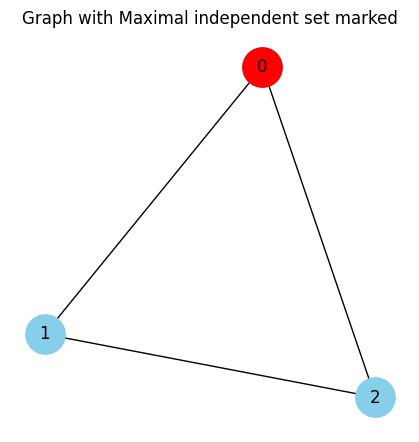

In [4]:
import networkx as nx

G3 = nx.cycle_graph(3)
draw_graph(G3,[0])

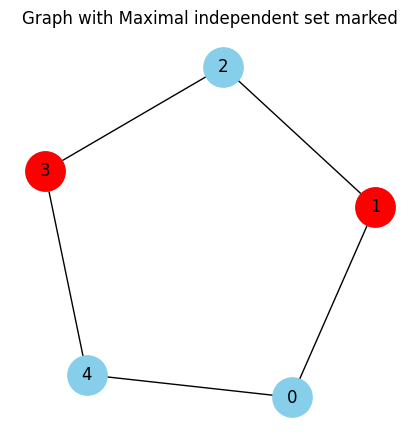

In [5]:
G5 = nx.cycle_graph(5)
draw_graph(G5,[1,3])

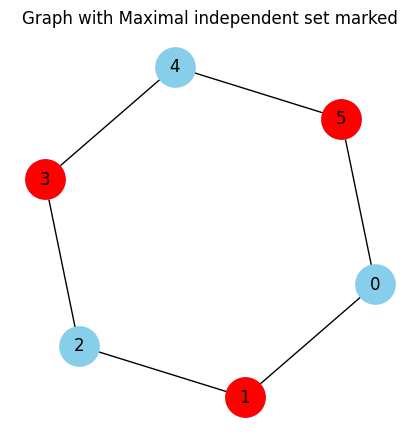

In [6]:
G6 = nx.cycle_graph(6)
draw_graph(G6,[1,3,5])

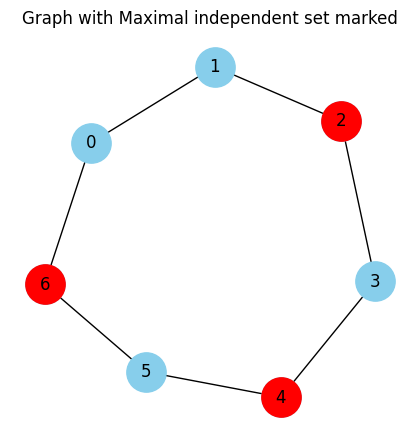

In [7]:
G7 = nx.cycle_graph(7)
draw_graph(G7,[2,4,6])

### Maximal independent set cost function

For maximal independent set problem the QUBO can be formulated as
$$
C(x) = - \sum_{v \in V} x_v + 2\sum_{(u, v) \in E}x_u \cdot x_v
$$
*   The first term maximizes number of vertices in the set
*   The second term penalizes for choosing vertices which have an edge
*   x is a binary string where
   *  $x_i=1$ represents ith node being in the set
   *  $x_i=0$ represents ith node not being in the set






In [8]:
from qiskit_optimization.problems import QuadraticProgram

def maximal_independent_set_qubo(graph):
    qp = QuadraticProgram(name= "MIS")

    # Define binary variables for each node
    for node in graph.nodes():
        qp.binary_var(name=f'x_{node}')

    # Add objective function: maximize the number of nodes in the independent set
    linear = { f'x_{node}': -1 for node in graph.nodes()}
    quadratic = {(f'x_{i}',f'x_{j}') : 2 for i,j in graph.edges()}
    qp.minimize(linear = linear, quadratic= quadratic)

    return qp

In [9]:
test = maximal_independent_set_qubo(G3)
print(test.prettyprint())

Problem name: MIS

Minimize
  2*x_0*x_1 + 2*x_0*x_2 + 2*x_1*x_2 - x_0 - x_1 - x_2

Subject to
  No constraints

  Binary variables (3)
    x_0 x_1 x_2



### Solve using gate based QAOA using VQE

The steps are as follows

1.  Encode the QUBO into a hamiltonian.
2.  To find ground state, we use VQE circuits
  -  We use classical optimization techniques to tweak the parameters of VQE circuit to minimize the expectation value of hamiltonian

The below section shows the training curve with reducing cost function and graphs with their calculated maximal independent set


In [10]:
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import SPSA
from qiskit.primitives import Sampler
from qiskit_optimization.applications.optimization_application import OptimizationApplication

import numpy as np

def find_maximal_independet_set(eigenstate):
  sample = OptimizationApplication.sample_most_likely(eigenstate)
  nodes = [i for i,chosen in enumerate(sample) if chosen == 1]
  return nodes

def print_stats(result):
  print("------- Stats ---------")
  print(f"Optimizing time : {result.optimizer_time:.3f}s")
  print(f"Cost function evaluations : {result.cost_function_evals}")

  eigenstate = result.eigenstate
  probability = max(result.eigenstate.values())
  print(f"Probability of best outcome :{probability}")

def plot_evaluations(eval_counts, eval_values):
  plt.figure(figsize=(8, 4))
  plt.plot(eval_counts, np.real(eval_values), marker='o', linestyle='-')
  plt.xlabel('Iteration')
  plt.ylabel('C(x)')
  plt.title('Cost vs iteration')
  plt.show()

def solve(qubo):
  qubitOp, offset = qubo.to_ising()
  optimizer = SPSA(maxiter=300)
  ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")

  eval_values = []
  eval_counts = []
  def callback(eval_count, parameters, mean, std):
      eval_values.append(mean)
      eval_counts.append(eval_count)

  vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer, callback=callback)

  result = vqe.compute_minimum_eigenvalue(qubitOp)
  plot_evaluations(eval_counts, eval_values)
  print_stats(result)

  return result

In [11]:
def mis_vqe(graph):
  qubo = maximal_independent_set_qubo(graph)
  result = solve(qubo)
  maximal_independent_set = find_maximal_independet_set(result.eigenstate)
  draw_graph(graph, maximal_independent_set)

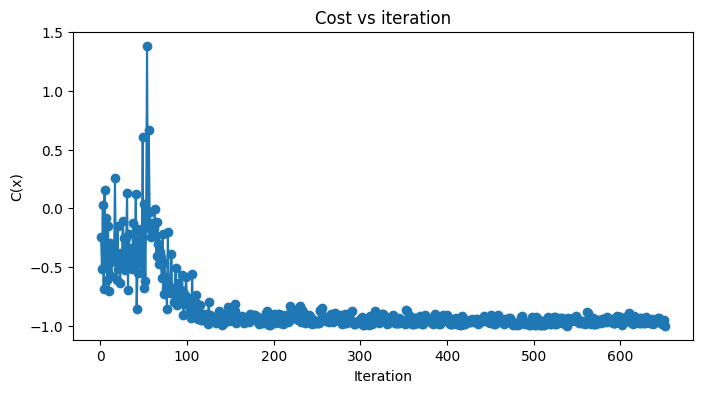

------- Stats ---------
Optimizing time : 3.117s
Cost function evaluations : 600
Probability of best outcome :0.9343087435904608


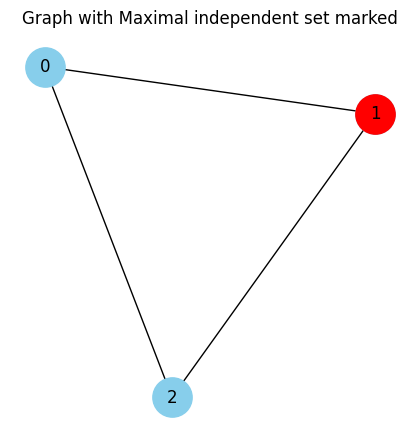

In [12]:
mis_vqe(G3)

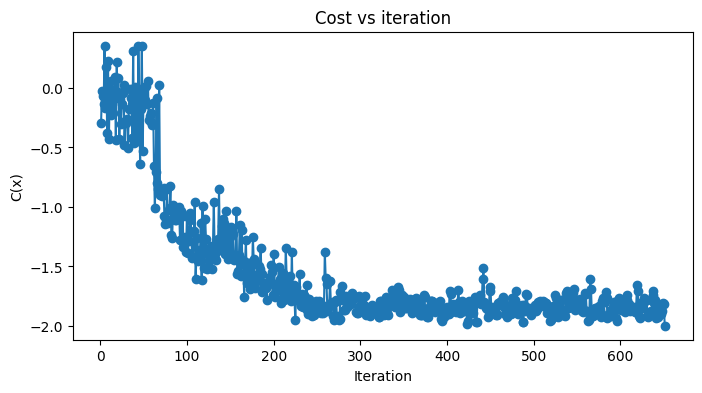

------- Stats ---------
Optimizing time : 9.985s
Cost function evaluations : 600
Probability of best outcome :0.850301062233716


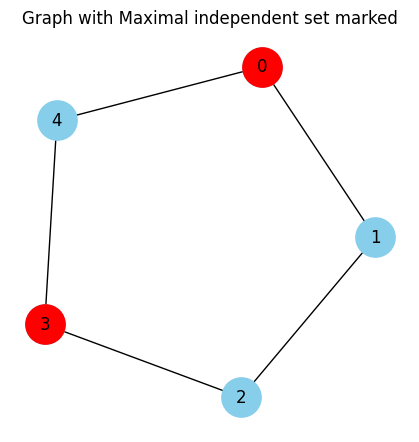

In [13]:
mis_vqe(G5)

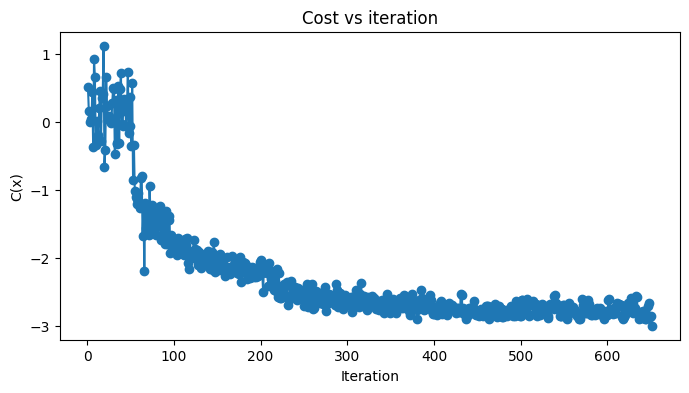

------- Stats ---------
Optimizing time : 17.572s
Cost function evaluations : 600
Probability of best outcome :0.7730396554135581


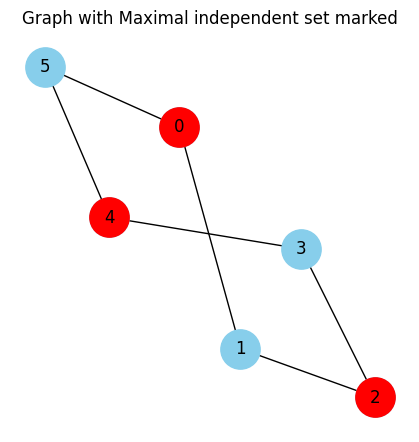

In [14]:
mis_vqe(G6)

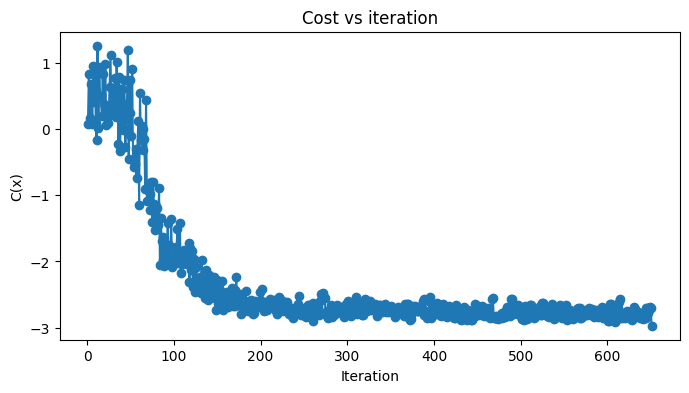

------- Stats ---------
Optimizing time : 17.176s
Cost function evaluations : 600
Probability of best outcome :0.78507034867533


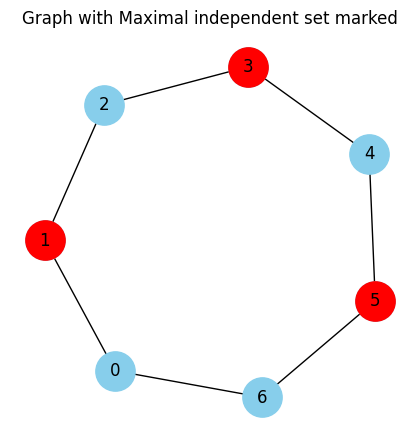

In [15]:
mis_vqe(G7)

### Solving using Quantum adiabatic QAOA using Rydberg atoms
The steps are as follows
1. Encode the QUBO into a hamiltonian
  - Here we use Rydberg atoms. These atoms have a special behaviour that when two atoms are closer than `Rydberg radius` both of them can't be at excited rydberg state
  - So in our graph if two nodes are connected by an edge they should be within the rydberg radius, else they must be farther than that.
  - Finding ground state of hamiltonian for such arrangement of atoms will solve the MIS problem
2. Use Quantum adiabatic algorithm to find the ground state of hamiltonian
  - It involves gradually changing a system's Hamiltonian from an initial simple form to a final form that encodes the problem, ensuring the system stays in its lowest energy state, allowing the solution to be extracted


In [16]:
import networkx as nx
import numpy as np
from pulser import Register

def map_cyclic_graph_to_register(cyclic_graph, distance):
    num_nodes = len(cyclic_graph.nodes)
    angle = 2 * np.pi / num_nodes
    radius = distance / (2 * np.sin(angle/2))

    # Calculate the positions of atoms in the cyclic arrangement
    atom_positions = {node: (radius * np.cos(i * angle), radius * np.sin(i * angle))
                      for i, node in enumerate(cyclic_graph.nodes)}

    # Create a register using the atom positions
    coordinates = list(atom_positions.values())
    register = Register.from_coordinates(coordinates)

    return register

def draw_reg(reg, rb):
  reg.draw(
      blockade_radius=rb,
      draw_graph=True,
      draw_half_radius=True,
  )

Below we see position of atoms for cyclic graph of 5 atoms <br>
Notice that atoms with edges between them have overlapping regions<br>
The radius of green circle is the rydberg blockade radius

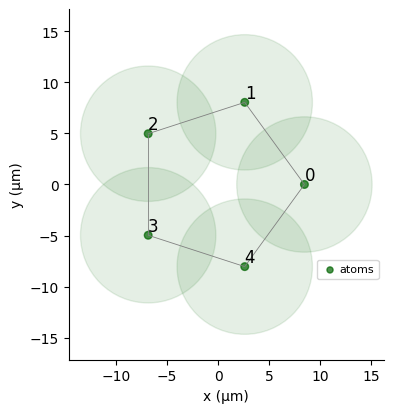

In [17]:
from pulser.devices import DigitalAnalogDevice

OMEGA = 1.0
rb = DigitalAnalogDevice.rydberg_blockade_radius(OMEGA)
edge_length = 0.75 * rb # edge_length < rb to create overlapping regions
reg = map_cyclic_graph_to_register(G5,edge_length)
draw_reg(reg,rb)

In [18]:
from pulser import Pulse
from pulser.waveforms import InterpolatedWaveform

delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 6000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

ADIABATIC_PULSE = Pulse(
    InterpolatedWaveform(T, [1e-9, OMEGA, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)

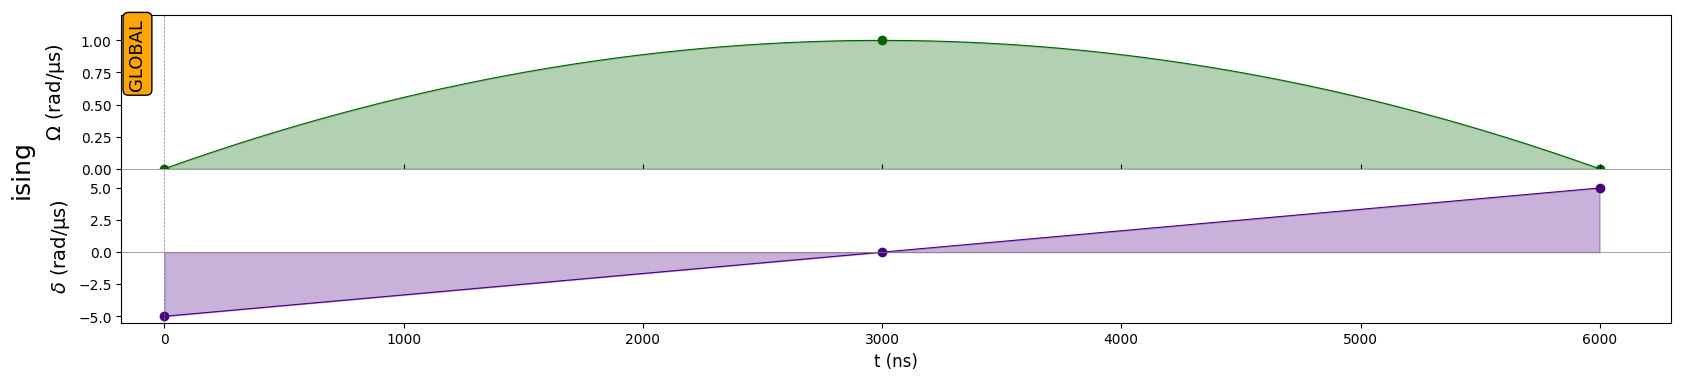

In [19]:
from pulser import Sequence

seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(ADIABATIC_PULSE, "ising")
seq.draw()

In [20]:
from pulser_simulation import QutipEmulator

def mis_adiabatic(graph):
  rb = DigitalAnalogDevice.rydberg_blockade_radius(OMEGA)
  edge_length = rb * 0.75 # edge_length < rb to create overlapping region
  reg = map_cyclic_graph_to_register(graph, edge_length)

  seq = Sequence(reg, DigitalAnalogDevice)
  seq.declare_channel("ising", "rydberg_global")
  seq.add(ADIABATIC_PULSE, "ising")

  simul = QutipEmulator.from_sequence(seq)
  results = simul.run()
  final = results.get_final_state()
  count_dict = results.sample_final_state()
  plot_distribution(count_dict)

  predicted_outcome = max(count_dict, key=lambda k: count_dict[k])

  nodes_to_color = [i for i,bit in enumerate(predicted_outcome) if bit == '1']
  draw_graph(graph, nodes_to_color)


/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


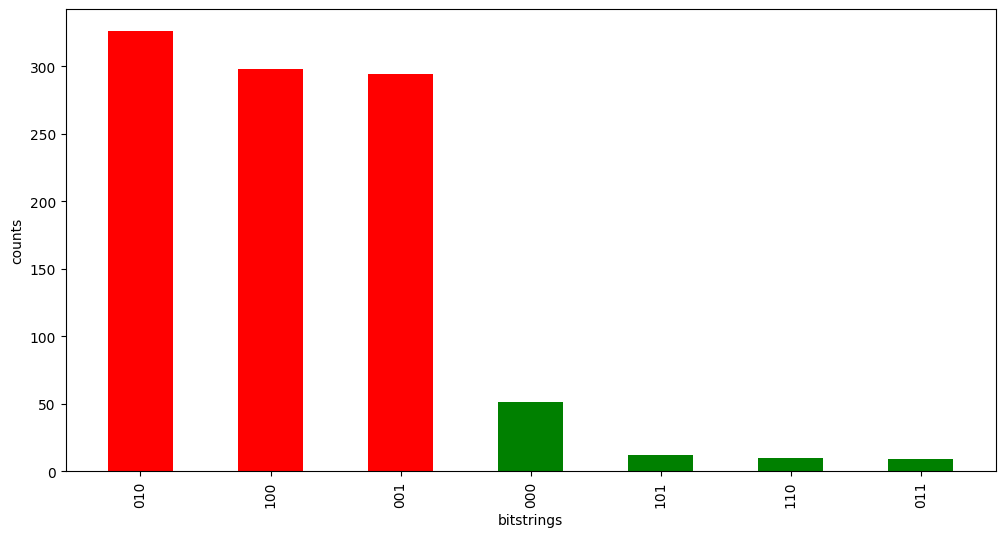

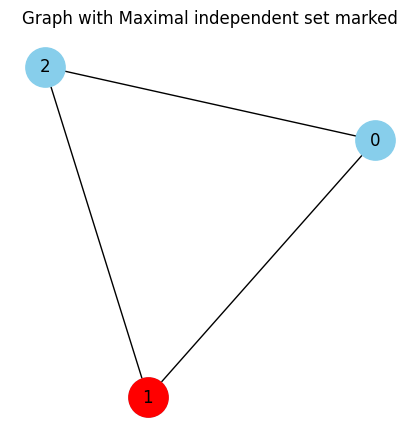

In [21]:
mis_adiabatic(G3)

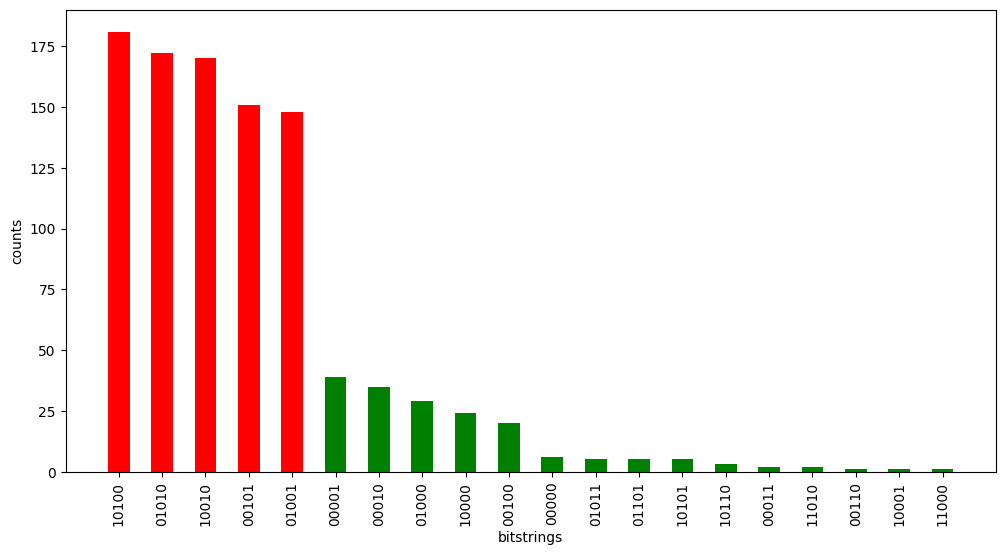

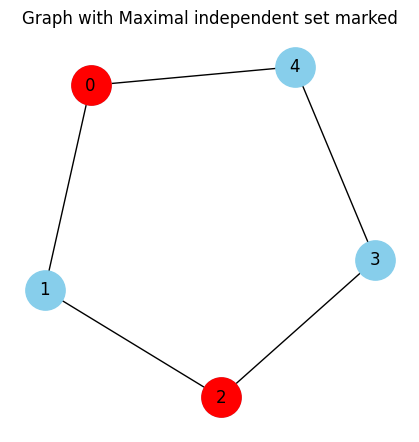

In [22]:
mis_adiabatic(G5)

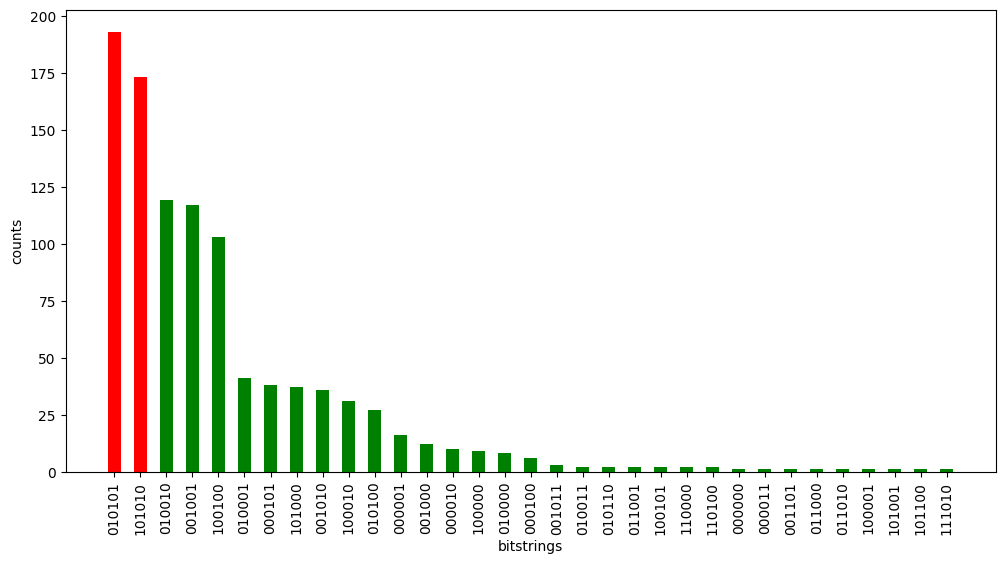

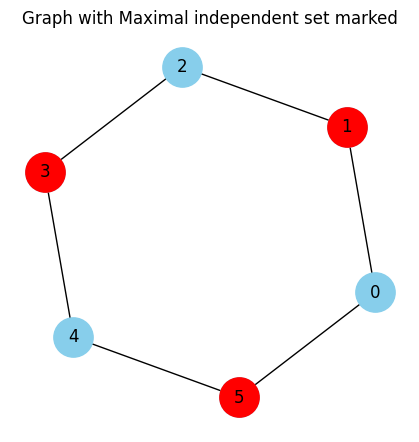

In [23]:
mis_adiabatic(G6)

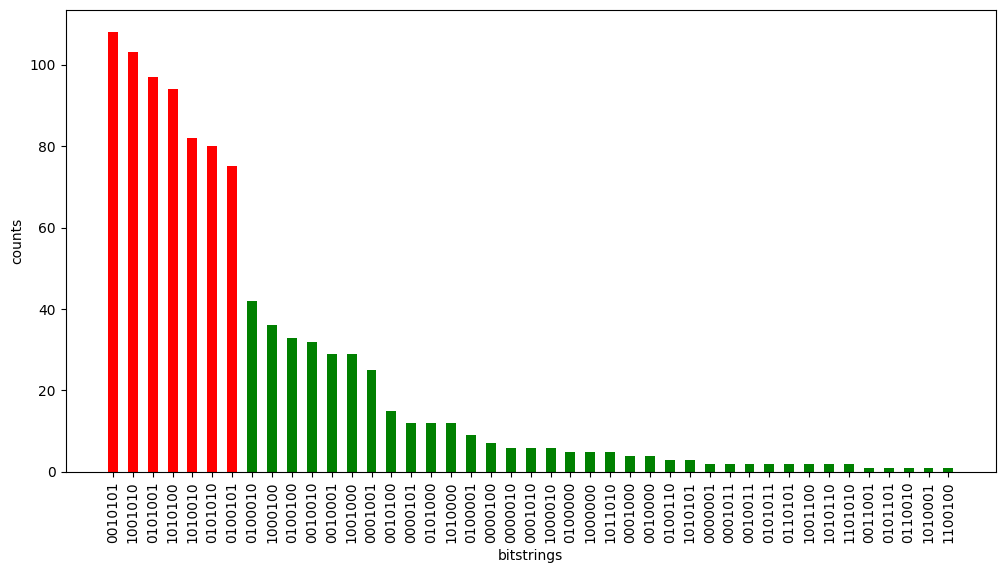

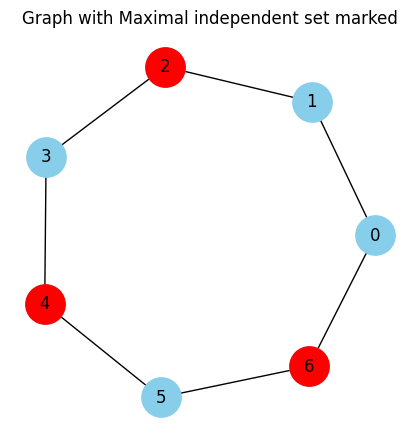

In [24]:
mis_adiabatic(G7)

### Analysis